In [20]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from models import VDT_models
import argparse
import os
from PIL import Image   
import numpy as np
import utils

from utils import center_crop_arr, interpolate_pos_embed, load_checkpoint

In [21]:
parser = argparse.ArgumentParser()
parser.add_argument("--model", type=str, choices=list(VDT_models.keys()), default="VDT-L/2")
parser.add_argument("--vae", type=str, choices=["ema", "mse"], default="ema")
parser.add_argument("--image-size", type=int, default=128)
parser.add_argument("--num-classes", type=int, default=1)
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--cfg-scale", type=float, default=4.0)
parser.add_argument("--num-sampling-steps", type=int, default=500)
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--num_frames", type=int, default=16)
parser.add_argument("--condition_frames", type=int, default=8)
parser.add_argument("--ckpt", type=str, default='physion_collide.pt')
parser.add_argument('--device', default='cuda')
parser.add_argument('--mode', default='video')
args = parser.parse_args([])


In [3]:
# Setup PyTorch:
torch.manual_seed(args.seed)
torch.set_grad_enabled(False)

device = torch.device(args.device)

In [4]:
# Load model:
latent_size = args.image_size // 8
print('latend size', latent_size)
additional_kwargs = {'num_frames': args.num_frames,
            'mode': args.mode} 
model = VDT_models[args.model](
    input_size=latent_size,
    num_classes=args.num_classes,
    num_frames=args.num_frames,
    mode=args.mode
).to(device)


model, _ = load_checkpoint(model, args.ckpt)
model = model.to(device)   

model.eval()  # important!


latend size 16


VDT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=1152, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1152, out_features=1152, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(2, 1152)
  )
  (time_drop): Dropout(p=0, inplace=False)
  (blocks): ModuleList(
    (0): VDTBlock(
      (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=1152, out_features=3456, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1152, out_features=1152, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=1152, out_features=4608, bia

In [12]:
# create diffusion and vea tokenizer
diffusion = create_diffusion(str(args.num_sampling_steps))
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").to(device)

In [23]:
transform = transforms.Compose([
        transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, args.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
    ])


# Conditional Frames Load (feel free to change):

video_path = 'conditional_frames'
start_idx = 20
frame_offset = 3

filename = os.path.join(video_path, '{:06d}.jpg')
frames = [
    Image.open(filename.format(start_idx +
                                n * frame_offset)).convert('RGB')
    for n in range(args.condition_frames)
]
frames = [transform(img) for img in frames]
x = torch.stack(frames).unsqueeze(0)

In [24]:
if args.condition_frames > 0:
    B, T, C, H, W = x.shape
    condition_frame = x.detach().clone().to(device=device)
    condition_x = x.view(-1, C, H, W).to(device=device)       
    with torch.no_grad():
        # Map input images to latent space + normalize latents:
        condition_x = vae.encode(condition_x).latent_dist.sample().mul_(0.18215)
    condition_x = condition_x.view(-1, args.condition_frames, 4, condition_x.shape[-2], condition_x.shape[-1])

# Create sampling noise:
z = torch.randn(1, args.num_frames - args.condition_frames, 4, latent_size, latent_size, device=device)
y = torch.tensor(0, device=device)

model_kwargs = dict(y=y)
sample_fn = model.forward

In [25]:
# Sample images:

z = z.permute(0, 2, 1, 3, 4)
samples = diffusion.p_sample_loop(
    sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device, condition_frames=condition_x
)
if False: # Set True to enable longer predict frames
    z = torch.randn(1, args.num_frames - args.condition_frames, 4, latent_size, latent_size, device=device)
    z = z.permute(0, 2, 1, 3, 4)
    samples_second = diffusion.p_sample_loop(
        sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device, condition_frames=samples.permute(0, 2, 1, 3, 4)
    )
    samples = torch.cat([samples, samples_second], dim=2)

samples = samples.permute(0, 2, 1, 3, 4).reshape(-1, 4, latent_size, latent_size)
samples = vae.decode(samples / 0.18215).sample

samples = samples.reshape(args.batch_size, -1, samples.shape[-3], samples.shape[-2], samples.shape[-1])
samples = torch.cat([condition_frame, samples], dim=1).reshape(-1, samples.shape[-3], samples.shape[-2], samples.shape[-1])

  0%|          | 0/500 [00:00<?, ?it/s]

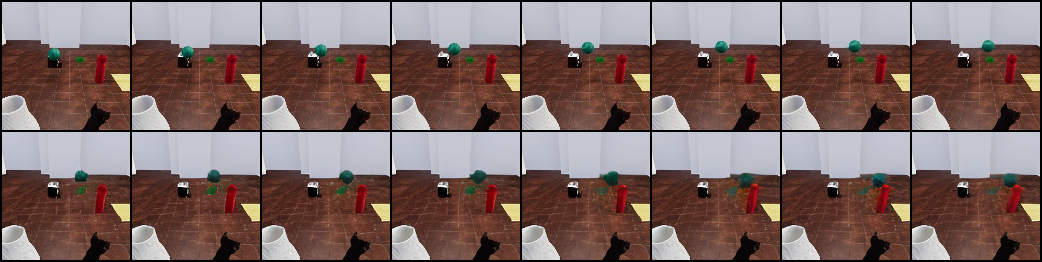

In [26]:
save_image(samples, "results/physion_Collide.png", nrow=8, normalize=True, value_range=(-1, 1))

from IPython.display import Image, display
display(Image(filename="results/physion_Collide.png"))